In [2]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


2025-03-24 14:10:54.088576: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 14:10:54.190900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 14:10:54.294921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742821854.396220   58583 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742821854.421903   58583 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742821854.607200   58583 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [4]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [5]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [6]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])

20

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [7]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
print(f"Feature vector length: {featveclen}")
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
data_aug_factor = 1
 
class_ids_aug = np.concatenate(
    [np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames]
)

X = np.zeros((data_aug_factor * sum(naudio.values()), featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]
            X[s * nclass * naudio[classname] + class_idx * naudio[classname] + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)
# Assuming classnames is already defined

# Print the names of the classes
print("Class names:", classnames)


X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()
classnames = np.unique(y)

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for classname, count in zip(unique_classes, class_counts):
    print(f"Class '{classname}': {count} samples")


Feature vector length: 400
Class names: ['chainsaw', 'fire', 'fireworks', 'gun']
Shape of the feature matrix : (259, 400)
Number of labels : 259
Class 'chainsaw': 80 samples
Class 'fire': 59 samples
Class 'fireworks': 80 samples
Class 'gun': 40 samples


You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

In [8]:
n = 14  # Number of principal components kept
model_pca = PCA(n_components=n, whiten=True)
# [4] Model training and selection.
K = 8
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")

model_rf = RandomForestClassifier(n_estimators=100, 
                             max_depth=2,
                             min_impurity_decrease=0.01
                             ,min_samples_leaf=2,
                             min_samples_split=3,
                             random_state=0)
model_lda = LDA(
    solver="svd",
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
) 



As for the toy example, we keep the ``accuracy`` and ``confusion matrix`` as performance metrics. <br>

Note that here we are not especially interested in a model selection hence we only split the dataset in training and testing parts but we don't split the training set in learning/validation parts. The models are trained on the entire training set.

<font size=5 color=#009999> 2.6. Augmenting the data </font> <br>

In order to make our classifier more robust to some common transformations of the audio signal such as ``time shift``, ``AWGN``, or a ``transfer function``, an idea consists in feeding the classifier with such transformations. A popular approach is to create new feature vectors based on transformed versions of the sounds from the original dataset, this is called ``data augmentation``. Data augmentation is also often used when there is few data to train a model. <br>

The functions to augment your data are written in ``utils/audio_student.py``, we already implemented ``time_shift``, ``echo`` and ``spectro_aug_timefreq_masking`` for you. Try to implement ``scaling``, ``add_noise``, ``filter``, ``add_bg`` and even more data augmentation techniques if you want, and check their working in the cell below. <br>

<u>Tip</u>: to avoid restarting the notebook kernel for each modification, you can temporarily insert the ``AudioUtil`` class in a new cell and make your tests until it is working as expected. 

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun o

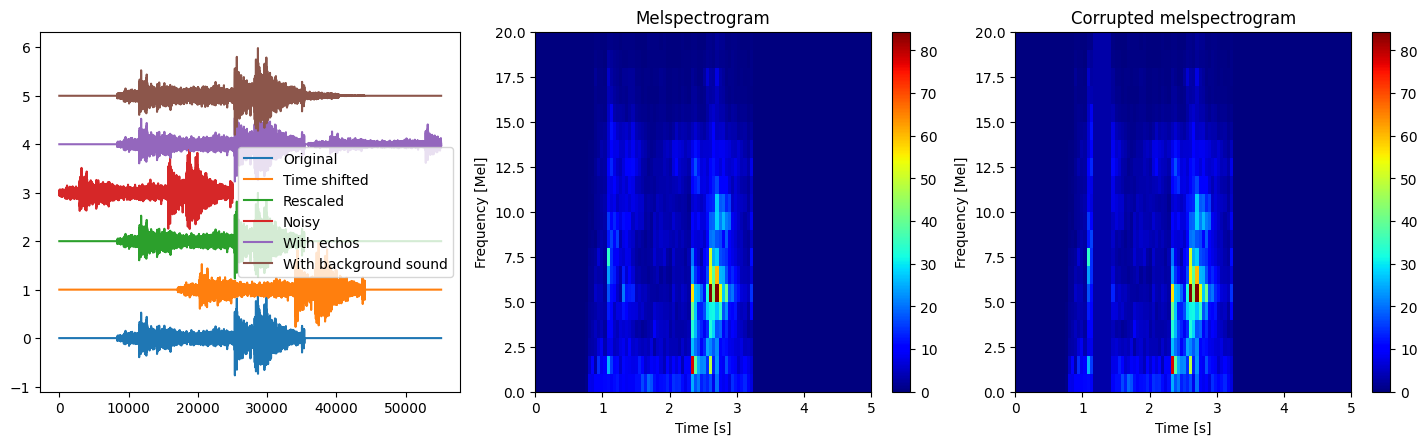

In [9]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["fire", 2]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)
audio_tmp = AudioUtil.open(sound)
AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.5)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio_tmp, sigma=1e-4)  # Create a copy before adding noise
audio6 = AudioUtil.echo(audio2)
audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [ ]:
### TO RUN
myds.mod_data_aug([ "echo", "noise" ,"time_shift"])
print(classnames)

# Initialisation des matrices de caractéristiques et des étiquettes
X_aug = np.zeros((myds.data_aug_factor * sum(naudio.values()), featveclen))
y_aug = np.empty((myds.data_aug_factor * sum(naudio.values())), dtype=object)

print(f"Shape of the feature matrix : {X_aug.shape}")

# Génération des vecteurs de caractéristiques et des étiquettes
for s in range(myds.data_aug_factor):
    offset = 0
    for class_idx, classname in enumerate(classnames):
        num_samples = naudio[classname]  # Number of samples for the current class
        for idx in range(num_samples):
            featvec = myds[classname, idx]
            X_aug[s * sum(naudio.values()) + offset + idx, :] = featvec
            y_aug[s * sum(naudio.values()) + offset + idx] = classname
        offset += num_samples  # Update the offset for the next class

y_aug = np.array(y_aug)

# Sauvegarde des matrices de caractéristiques
np.save(fm_dir + "feature_matrix_2D_aug2.npy", X_aug)
np.save(fm_dir + "labels_2D_aug2.npy", y_aug)

# Chargement des matrices de caractéristiques (si nécessaire)
X_aug = np.load(fm_dir + "feature_matrix_2D_aug.npy")
y_aug = np.load(fm_dir + "labels_2D_aug.npy",allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

['chainsaw' 'fire' 'fireworks' 'gun']
Shape of the feature matrix : (1295, 400)
Shape of the feature matrix : (1295, 400)
Number of labels : 1295


<font size=5 color=#009999> 2.7. Getting it all together </font> <br>

Now that some aspects to be considered during the model training and analysis have been presented, it remains to train and save a final model that will be used for further predictions.

(906, 400)
Mean Accuracy without PCA: 79.03%
PCA components: 1, Mean Accuracy: 42.49%
PCA components: 2, Mean Accuracy: 56.18%
PCA components: 3, Mean Accuracy: 63.58%
PCA components: 4, Mean Accuracy: 66.23%
PCA components: 5, Mean Accuracy: 68.00%
PCA components: 6, Mean Accuracy: 68.55%
PCA components: 7, Mean Accuracy: 73.29%
PCA components: 8, Mean Accuracy: 72.74%
PCA components: 9, Mean Accuracy: 73.30%
PCA components: 10, Mean Accuracy: 75.50%
PCA components: 11, Mean Accuracy: 74.62%
PCA components: 12, Mean Accuracy: 73.85%
PCA components: 13, Mean Accuracy: 72.75%
PCA components: 14, Mean Accuracy: 71.97%
PCA components: 15, Mean Accuracy: 73.52%
PCA components: 16, Mean Accuracy: 73.08%
PCA components: 17, Mean Accuracy: 72.64%
PCA components: 18, Mean Accuracy: 72.74%
PCA components: 19, Mean Accuracy: 72.41%
PCA components: 20, Mean Accuracy: 72.63%


NameError: name 'PdfPages' is not defined

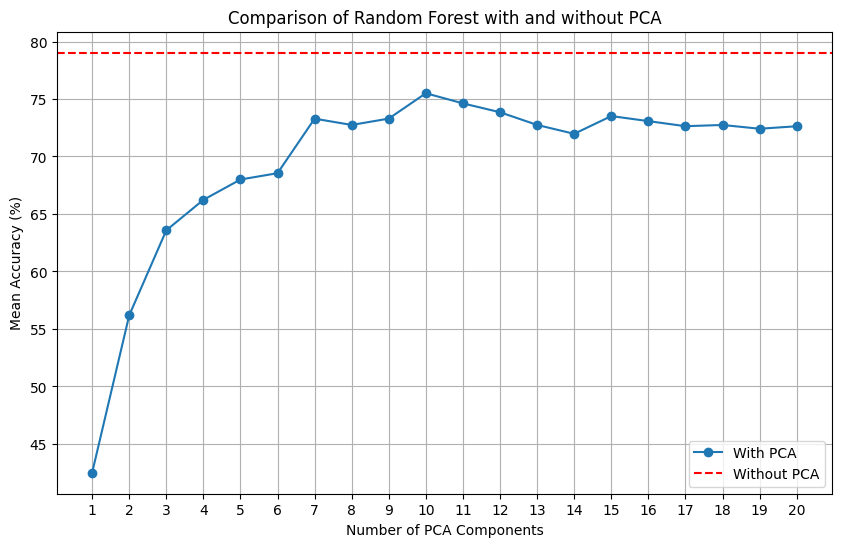

In [11]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, random_state=42)
# [2] (optional) Data normalization
X_train_normalized = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalized = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)
print(X_train_normalized.shape)
X_train_normalized -= np.mean(X_train_normalized, axis=0)
X_test_normalized -= np.mean(X_test_normalized, axis=0)
# [3] Initialize the Random Forest model
best_rf = RandomForestClassifier(
    max_depth=10,
    min_impurity_decrease=0.001,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

# [4] Evaluate RF without PCA
n_splits = 5  # Number of cross-validation splits
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies_no_pca = []
for train_idx, val_idx in kf.split(X_train_normalized, y_train):
    # Train and evaluate the Random Forest model without PCA
    best_rf.fit(X_train_normalized[train_idx], y_train[train_idx])
    y_pred = best_rf.predict(X_train_normalized[val_idx])
    accuracy = accuracy_score(y_train[val_idx], y_pred)
    accuracies_no_pca.append(accuracy)

mean_accuracy_no_pca = np.mean(accuracies_no_pca)
print(f"Mean Accuracy without PCA: {mean_accuracy_no_pca * 100:.2f}%")

# [5] Evaluate RF with PCA
pca_components = range(1, min(X_train_normalized.shape[1], 21))  # Test 1 to 20 components
mean_accuracies_with_pca = []

for n_components in pca_components:
    accuracies_with_pca = []
    pca = PCA(n_components=n_components, whiten=True)
    
    for train_idx, val_idx in kf.split(X_train_normalized, y_train):
        # Apply PCA
        
        X_train_pca = pca.fit_transform(X_train_normalized[train_idx])
        X_val_pca = pca.transform(X_train_normalized[val_idx])
        
        # Train and evaluate the Random Forest model
        best_rf.fit(X_train_pca, y_train[train_idx])
        y_pred = best_rf.predict(X_val_pca)
        accuracy = accuracy_score(y_train[val_idx], y_pred)
        accuracies_with_pca.append(accuracy)
    
    # Compute the mean accuracy for the current number of PCA components
    mean_accuracy_with_pca = np.mean(accuracies_with_pca)
    mean_accuracies_with_pca.append(mean_accuracy_with_pca)
    print(f"PCA components: {n_components}, Mean Accuracy: {mean_accuracy_with_pca * 100:.2f}%")

# [6] Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pca_components, [acc * 100 for acc in mean_accuracies_with_pca], marker='o', label='With PCA')
plt.axhline(y=mean_accuracy_no_pca * 100, color='r', linestyle='--', label='Without PCA')
plt.xlabel('Number of PCA Components')
plt.xticks(pca_components)
plt.ylabel('Mean Accuracy (%)')
plt.title('Comparison of Random Forest with and without PCA')
plt.grid(True)
plt.legend()

# Save the plot as a PDF
pdf_filename = "rf_with_vs_without_pca.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()
    plt.close()

print(f"Plot saved as {pdf_filename}")

Shape of the feature matrix: [[0.07407518 0.13449308 0.12651467 ... 0.00640234 0.00600988 0.00590183]
 [0.03023914 0.02422214 0.03534772 ... 0.00409535 0.00443034 0.00424508]
 [0.02996157 0.03718689 0.05187375 ... 0.00556983 0.00558178 0.00543106]
 ...
 [0.06542581 0.08226574 0.07970988 ... 0.02877227 0.03932218 0.03135471]
 [0.01161049 0.02351798 0.02409543 ... 0.00711885 0.00805974 0.00903462]
 [0.02089042 0.02960639 0.01987675 ... 0.00843809 0.00876161 0.00827459]]
Number of labels: (1295,)
(1295, 400)
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Mean accuracy with Random Forest 5-Fold CV: 79.6%
Std deviation in accuracy with 5-Fold CV: 3.1%
Test set accuracy with Random Forest: 79.69%


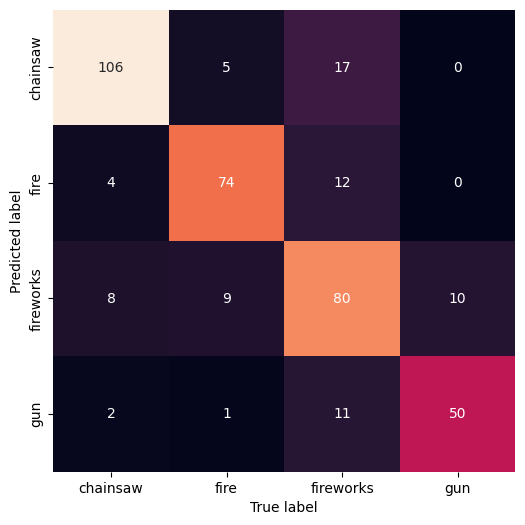

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import pickle
from sklearn.decomposition import PCA

# [1] Create dataset of feature vectors and split it.
print(f"Shape of the feature matrix: {X_aug}")
print(f"Number of labels: {y_aug.shape}")
print(X_aug.shape)
print(np.linalg.norm(X_aug, axis=1, keepdims=True))

X_aug = np.load(fm_dir + "feature_matrix_2D_aug.npy")
y_aug = np.load(fm_dir + "labels_2D_aug.npy", allow_pickle=True)

X_aug = X_aug / np.linalg.norm(X_aug, axis=1, keepdims=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.3, stratify=y_aug
)  # random_state=1
# X_train -= np.mean(X_train, axis=0)
# X_test -= np.mean(X_test, axis=0)
# [2] (optional) Data normalization



# Apply PCA with 10 components

# pca = PCA(n_components=10, whiten=True)

# X_train_pca = pca.fit_transform(X_train_normalized)
# X_test_pca = pca.transform(X_test_normalized)

# Save the PCA model
# filename_pca = "pca_10_components.pickle"
# pickle.dump(pca, open(model_dir + filename_pca, "wb"))

# [3] Model training and selection using Random Forest
best_rf = RandomForestClassifier(
    max_depth=10,
    min_impurity_decrease=0.001,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
accuracies_rf = np.zeros((n_splits,))

for k, idx in enumerate(kf.split(X_train, y_train)):
    idx_learn, idx_val = idx
    best_rf.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_rf = best_rf.predict(X_train[idx_val])
    accuracies_rf[k] = accuracy_score(y_train[idx_val], prediction_rf)

# [4] Save the trained model
filename_model = "best_rf_model.pickle"
pickle.dump(best_rf, open(model_dir + filename_model, "wb"))

# [5] Evaluate the model
print(f"Mean accuracy with Random Forest 5-Fold CV: {100 * accuracies_rf.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracies_rf.std():.1f}%")

y_pred = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with Random Forest: {accuracy_rf * 100:.2f}%")

# Show the confusion matrix
show_confusion_matrix(y_pred, y_test, classnames)

Mean power of class chainsaw: 0.04765186776927067 & Median power of class chainsaw: 0.04279712165901438
Mean power of class fire: 0.033254197823296666 & Median power of class fire: 0.028551786397621036
Mean power of class fireworks: 0.021888775124805058 & Median power of class fireworks: 0.015294954685624688
Mean power of class gun: 0.009821316184536553 & Median power of class gun: 0.00823494167506695


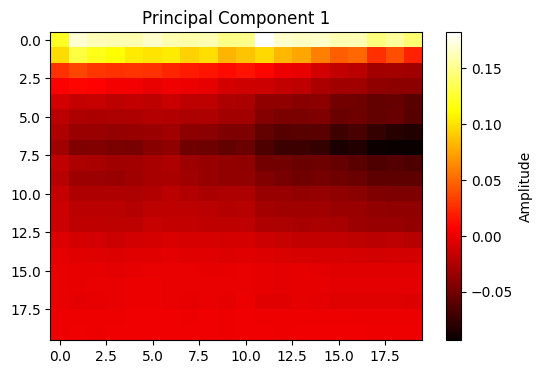

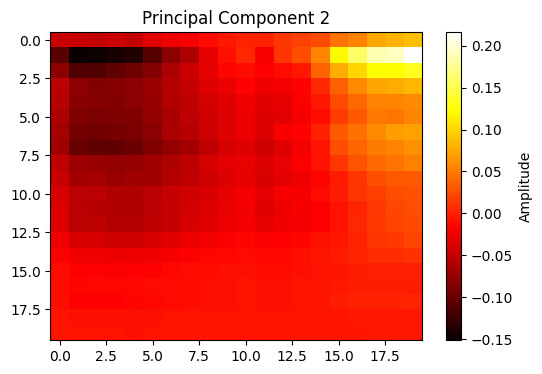

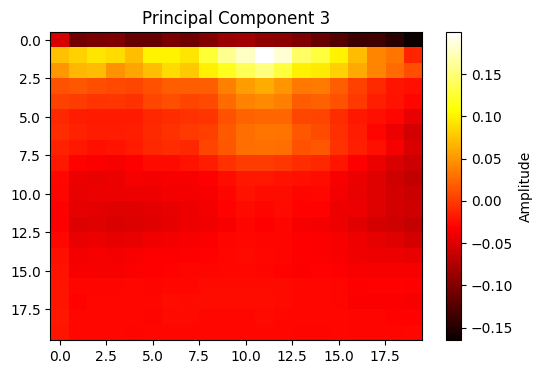

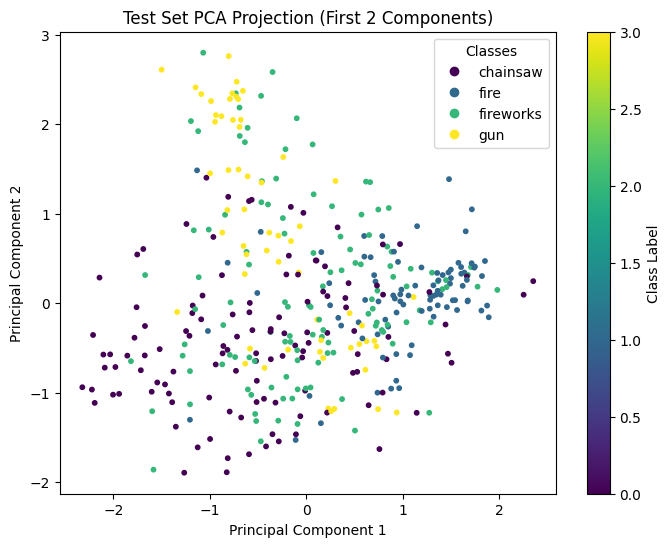

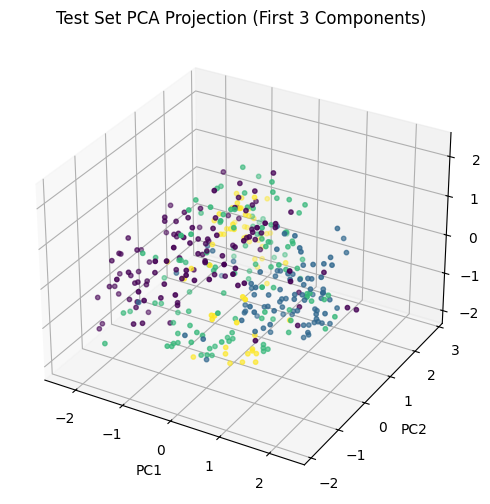

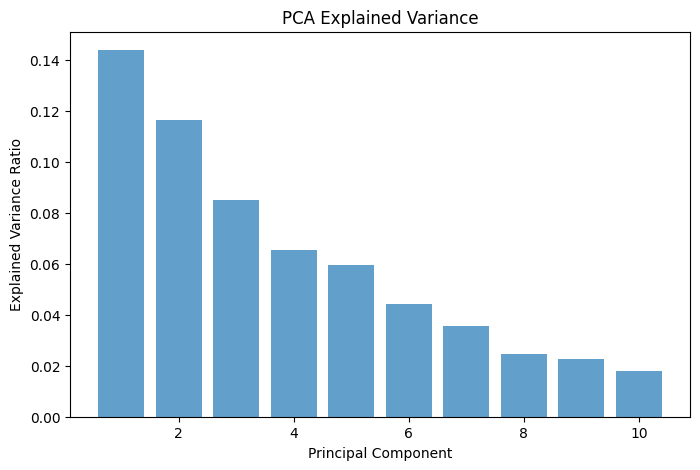

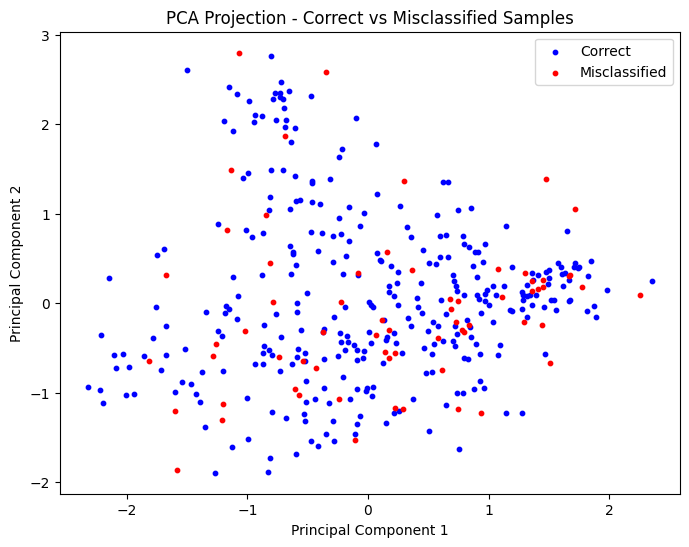

In [ ]:
class_means = {}
for cls in ["chainsaw", "fire","fireworks","gun"]:
    power_sum = 0
    for i in range(naudio[cls]):
        sound = dataset.__getitem__([cls, i])
        audio = AudioUtil.open(sound)
        power_sum += np.mean(audio[0] ** 2)
    class_means[cls] = power_sum / naudio[cls]
    
class_medians = {}
for cls in ["chainsaw", "fire","fireworks","gun"]:
    power_values = []
    for i in range(naudio[cls]):
        sound = dataset.__getitem__([cls, i])
        audio = AudioUtil.open(sound)
        power_values.append(np.mean(audio[0] ** 2))
    class_medians[cls] = np.median(power_values)
    
for cls in class_means:
    print(f"Mean power of class {cls}: {class_means[cls]} & Median power of class {cls}: {class_medians[cls]}")
    # Map class labels to numerical values
classnames = np.unique(y_aug)
class_to_num = {classname: num for num, classname in enumerate(classnames)}
y_test_num = np.array([class_to_num[label] for label in y_test])

# --- Visualizing the First Few Principal Components ---
for i in range(3):  # First 3 components only
    plt.figure(figsize=(6, 4))
    plt.imshow(pca.components_[i].reshape(20, 20), cmap="hot", aspect="auto")  # Adjust the reshape dimensions to match the original feature vector dimensions
    plt.title(f"Principal Component {i+1}")
    plt.colorbar(label="Amplitude")
    plt.show()

# --- Scatter Plot: Project Data into 2D or 3D Space ---
# 2D scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_num, cmap='viridis', s=10)
plt.title("Test Set PCA Projection (First 2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class Label")

# Add legend with class names
handles, _ = scatter.legend_elements()
plt.legend(handles, classnames, title="Classes")
plt.show()

# Optional: 3D scatter plot for better visual separation
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=y_test_num, cmap='viridis', s=10)
ax.set_title("Test Set PCA Projection (First 3 Components)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

# --- Variance Explained Plot ---
# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance")
plt.show()

# --- Inspect Test Samples in PCA Space ---
# Identify misclassified samples
misclassified = y_test != y_pred

# Plot PCA projections for correct and incorrect classifications
plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[~misclassified, 0], X_test_pca[~misclassified, 1], c='blue', label="Correct", s=10)
plt.scatter(X_test_pca[misclassified, 0], X_test_pca[misclassified, 1], c='red', label="Misclassified", s=10)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection - Correct vs Misclassified Samples")
plt.legend()
plt.show()